In [2]:
# Built-in libraries
import os
import re
import time
from datetime import datetime
import pytz
from itertools import compress
from math import log
from math import log2
import random

# NumPy, SciPy and Pandas
import numpy as np
from scipy.stats import gaussian_kde
from scipy.stats import iqr
import pandas as pd

# Scikit-Learn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabaz_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import sqeuclidean
from sklearn.neighbors import NearestNeighbors

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%matplotlib inline

# JoyPy
import joypy

# Workalendar
from workalendar.europe import Switzerland
from workalendar.europe import UnitedKingdom
from workalendar.usa import Colorado
from workalendar.usa import NewYork
from workalendar.usa import California
from workalendar.usa import Arizona
from workalendar.usa import Illinois
from workalendar.asia import Singapore
from workalendar.oceania import WesternAustralia

In [2]:
combined_profiles = pd.read_csv('final_profiles.csv')

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Generate building

In [3]:
def get_proportions(pd_labels):
    result = {}
    vals = pd_labels.value_counts()
    total = pd_labels.shape[0]
    for i in vals.index:
        result[i] = (vals.loc[i]/total)
    result['count'] = total
    return result

def get_list_of_proportions(profiles):
    return profiles.groupby('Building')[['cluster']].transform(get_proportions)

In [4]:
def get_dominant_clusters(proportions_mat):
    dominant_flag = np.max(proportions_mat, axis=1) > .5
    dominant_clusters = np.argmax(proportions_mat, axis=1)
    dominant_clusters[~dominant_flag] = -1
    return dominant_clusters

In [5]:
def build_df(profiles, k, algo, labels_dir):
    profiles['cluster'] = np.load('./%s/%s/params[k=%d].npy' % (labels_dir, algo, k))
    profiles['proportions'] = get_list_of_proportions(profiles)
    
    final_buildings = profiles.drop_duplicates(['Dataset', 'Building'])[['Dataset', 'Building', 'proportions', 'Industry', 'PSU', 'Sqm', 'Subindustry', 'Timezone', 'EUI', 'Climatezone', 'EUI Binned', 'Sqm Binned']]
    final_buildings.reset_index(drop=True, inplace=True)
    
    filtered_buildings = final_buildings.loc[final_buildings.proportions.map(lambda x: x['count']) >= 30, :]
    filtered_buildings.reset_index(drop=True, inplace=True)
    
    cluster_labels = profiles.cluster.unique()
    cluster_labels.sort()
    
    proportions_data = []

    for dic in filtered_buildings.proportions.tolist():
        proportions_data.append([])
        for label in cluster_labels:
            if label not in dic:
                proportions_data[-1].append(0)
            else:
                proportions_data[-1].append(dic[label])

    proportions_df = pd.DataFrame(proportions_data)
    
    buildings_df = filtered_buildings.drop('proportions', axis=1)
    buildings_df['dominant_cluster'] = get_dominant_clusters(proportions_df.as_matrix())
    return (buildings_df, proportions_df)

In [6]:
buildings, proportions = build_df(combined_profiles, 3, 'kmeans', 'final_labels')

### Binning
* Buildings with EUIs in the 1st, 2nd and 3rd thousandth quantile make up 88% of all buildings
* We only use these buildings for producing the benchmarking plots

In [305]:
# def rebuild_intervals(series):
#     results = []
#     for interval in series:
#         results.append(pd.Interval(max(0, interval.left), interval.right))
#     return pd.Series(results)

In [309]:
# buildings['EUI Binned'] = rebuild_intervals(pd.cut(buildings.EUI, 100))

In [290]:
# fourth_percentile = sorted(buildings['EUI Binned'].unique().tolist())[3]
# filter_values = [interval < fourth_percentile for interval in buildings['EUI Binned']]
# filtered_buildings = buildings.copy().loc[filter_values, :].drop('Sqm Binned', axis=1)

In [295]:
# filtered_buildings.head()

,Dataset,Building,Industry,PSU,Sqm,Subindustry,Timezone,EUI,Climatezone,EUI Binned,dominant_cluster
0,pecan,3831,Residential,Single_family_house,105.909466,NaN,America/Chicago,45.627032,2,"(0, 60.436]",2
1,pecan,3938,Residential,Single_family_house,104.051405,NaN,America/Chicago,20.858344,2,"(0, 60.436]",2
2,pecan,5371,Residential,Single_family_house,87.050148,NaN,America/Chicago,91.462989,2,"(60.436, 119.677]",2
3,pecan,9775,Residential,Single_family_house,130.528771,NaN,America/Chicago,40.263767,2,"(0, 60.436]",2
4,pecan,5218,Residential,Single_family_house,193.145420,NaN,America/Chicago,35.506750,2,"(0, 60.436]",2


* sample buildings without 'Others' and discard buildings PSUs containing only 1 building
* obtain 100 buildings

In [7]:
# buildings_sample = buildings.sample(100, random_state=42)
buildings_sample = buildings.loc[buildings.PSU != 'Others', :].sample(105, random_state=0)

In [8]:
psu_counts = buildings_sample['PSU'].value_counts()
conversion_set = psu_counts.index[psu_counts == 1]
discard_flags = buildings_sample['PSU'].isin(conversion_set)
buildings_sample = buildings_sample.loc[~discard_flags, :]

In [9]:
buildings_sample.shape

(100, 12)

In [10]:
buildings_sample.head()

,Dataset,Building,Industry,PSU,Sqm,Subindustry,Timezone,EUI,Climatezone,EUI Binned,Sqm Binned,dominant_cluster
539,ireland,6848,Residential,Single_family_house,148.644864,NaN,Europe/London,86.378296,4,"(75.0, 100.0]","(100.0, 200.0]",2
1467,ireland,5736,Residential,Single_family_house,120.773952,NaN,Europe/London,48.448526,4,"(25.0, 50.0]","(100.0, 200.0]",2
2546,genome,UnivClass_Antoinette,Education,College Classroom,3174.589780,College/University,America/Phoenix,105.640154,2,"(100.0, 125.0]","(500.0, 167889.636]",0
3683,genome2,howardian-community-education-centre,Government,Office,4858.995298,"City, County, State",Europe/London,27.698138,4,"(25.0, 50.0]","(500.0, 167889.636]",0
992,ireland,4645,Residential,Single_family_house,278.709120,NaN,Europe/London,41.086922,4,"(25.0, 50.0]","(200.0, 300.0]",2


In [11]:
buildings_sample['EUI Binned'].value_counts()

(25.0, 50.0]         23
(50.0, 75.0]         19
(75.0, 100.0]        17
(150.0, 5925.223]    13
(0, 25.0]            11
(100.0, 125.0]       10
(125.0, 150.0]        7
Name: EUI Binned, dtype: int64

In [12]:
buildings_sample['Dataset'].value_counts()

ireland       58
genome        17
genome2       15
utexas         4
pecan          3
MIT            2
washington     1
Name: Dataset, dtype: int64

In [13]:
buildings_sample['PSU'].value_counts()

Single_family_house            61
Office                         14
College Laboratory              7
Dormitory                       7
College Classroom               6
Primary/Secondary Classroom     5
Name: PSU, dtype: int64

In [121]:
buildings_sample.to_csv('buildings_sample.csv', index=False)

In [143]:
buildings.to_csv('buildings.csv', index=False)

### Rename PSUs with only 1 building to Others (Deprecated)

In [13]:
# psu_counts = buildings_sample['PSU'].value_counts()
# conversion_set = psu_counts.index[psu_counts == 1]
# conversion_flags = buildings_sample['PSU'].isin(conversion_set).tolist()
# new_PSUs = ['Others' if conversion_flags[i] else buildings_sample['PSU'].iloc[i] for i in range(buildings_sample.shape[0])]
# buildings_sample['PSU'] = new_PSUs

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


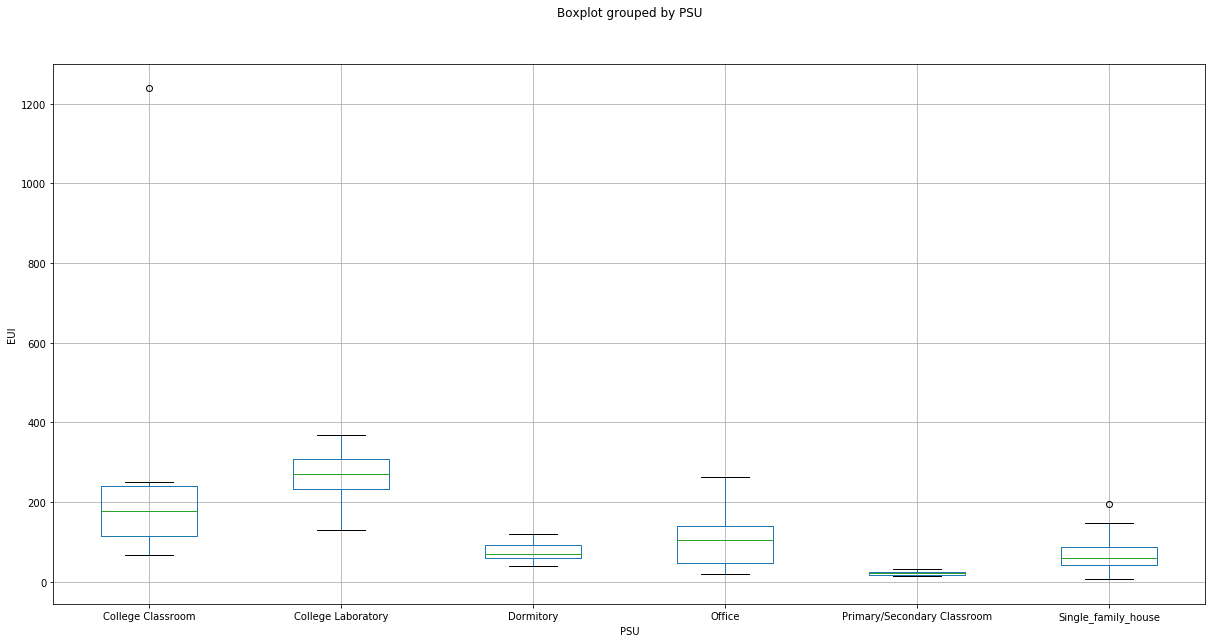

In [14]:
buildings_sample.boxplot('EUI', 'PSU', figsize=(20,10))
plt.title('')
plt.ylabel('EUI')
plt.show()
plt.close()

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


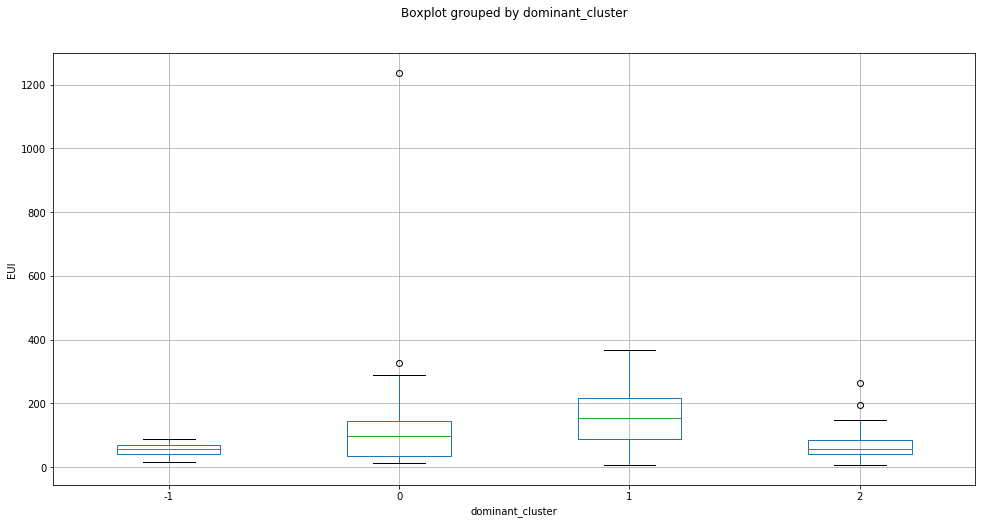

In [15]:
buildings_sample.boxplot('EUI', 'dominant_cluster', figsize=(16,8))
plt.title('')
plt.ylabel('EUI')
plt.show()
plt.close()

### Load-shape-based Bechmarking

In [16]:
def get_buildings_by_field(buildings, field, value):
    return buildings.loc[buildings[field] == value, ['Dataset', 'Building']]

In [17]:
def get_profiles(profiles, buildings):
    profiles_mat = profiles.as_matrix()
    buildings_mat = buildings.as_matrix()

    buildings_signatures = {(row[0], row[1]): row[-1] for row in buildings_mat}
    profiles_flags = [(row[0], row[1]) in buildings_signatures for row in profiles_mat]

    buildings_profiles = profiles.loc[profiles_flags, :].copy()
    dominant_clusters = [buildings_signatures[(row[0], row[1])] for row in buildings_profiles.as_matrix()]
    buildings_profiles['dominant_cluster'] = dominant_clusters
    return buildings_profiles

In [18]:
def get_quantile(profiles, quantile=0.5):
    return profiles.iloc[:, 3:3+24].quantile(quantile)

In [19]:
def plot_profiles(middle, upper, lower, value, save_dir):
    plt.figure(figsize=(16,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(middle, c=(1,0,0), label='Average Profile (%s)' % value)
    plt.plot(upper, '--', c=(0,0,0), label='75% Percentile')
    plt.plot(lower, '--', c=(0,0,0), label='25% Percentile')
    plt.xlabel('Time (h)')
    plt.ylabel('Normalized Energy Readings')
    plt.legend()
    plt.show()
    if type(value) is str:
        plt.savefig(save_dir + '/Benchmarking Plot (%s)' % value, bbox_inches='tight')
    else:
        plt.savefig(save_dir + '/Benchmarking Plot (%d)' % value, bbox_inches='tight')
    plt.close()

* EUI Type
* Deprecated

In [21]:
# interval_dict = {}
# intervals = sorted(buildings_sample['EUI Binned'].unique())
# interval_dict[intervals[0]] = 'Low'
# interval_dict[intervals[1]] = 'Medium'
# interval_dict[intervals[2]] = 'High'

In [70]:
# buildings_sample['EUI Type'] = [interval_dict[interval] for interval in buildings_sample['EUI Binned']]

In [ ]:
# buildings_sample['dominant_cluster + EUI Type'] = ['%s-[%s]' % (row['EUI Type'], row.dominant_cluster) for i, row in buildings_sample.iterrows()]

In [213]:
# plot_root = './benchmarking_plots'
# fields = ['dominant_cluster', 'EUI Type', 'dominant_cluster + EUI Type']
# for field in fields:
#     save_dir = '%s/%s' % (plot_root, field)
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
#     for value in sorted(buildings_sample[field].unique()):
#         profiles = get_profiles(combined_profiles, get_buildings_by_field(buildings_sample, field, value))
#         lower = get_quantile(profiles, quantile=0.25)
#         middle = get_quantile(profiles, quantile=0.5)
#         upper = get_quantile(profiles, quantile=0.75)
#         plot_profiles(middle, upper, lower, value, save_dir)

In [20]:
profiles_sample = get_profiles(combined_profiles, buildings_sample)

In [64]:
# conversion_flags = profiles_sample['PSU'].isin(set(['Industrial', 'College Laboratory', 'Fitness Center'])).tolist()
# new_PSUs = ['Others' if conversion_flags[i] else profiles_sample['PSU'].iloc[i] for i in range(profiles_sample.shape[0])]
# profiles_sample['PSU'] = new_PSUs

In [138]:
profiles_sample.to_csv('profiles_sample.csv', index=False)

In [144]:
profiles = get_profiles(combined_profiles, buildings)

In [162]:
profiles.to_csv('profiles.csv', index=False)

* get all buildings (without removing buildings with less than 30 profiles)

In [171]:
def build_df_complete(profiles, k, algo, labels_dir):
    profiles['cluster'] = np.load('./%s/%s/params[k=%d].npy' % (labels_dir, algo, k))
    profiles['proportions'] = get_list_of_proportions(profiles)
    
    final_buildings = profiles.drop_duplicates(['Dataset', 'Building'])[['Dataset', 'Building', 'proportions', 'Industry', 'PSU', 'Sqm', 'Subindustry', 'Timezone', 'EUI', 'Climatezone', 'EUI Binned', 'Sqm Binned']]
    final_buildings.reset_index(drop=True, inplace=True)
    
    cluster_labels = profiles.cluster.unique()
    cluster_labels.sort()
    
    proportions_data = []

    for dic in final_buildings.proportions.tolist():
        proportions_data.append([])
        for label in cluster_labels:
            if label not in dic:
                proportions_data[-1].append(0)
            else:
                proportions_data[-1].append(dic[label])

    proportions_df = pd.DataFrame(proportions_data)
    
    buildings_df = final_buildings.drop('proportions', axis=1)
    buildings_df['dominant_cluster'] = get_dominant_clusters(proportions_df.as_matrix())
    return (buildings_df, proportions_df)

In [172]:
buildings_complete, proportions_complete = build_df_complete(combined_profiles, 3, 'kmeans', 'final_labels')

In [183]:
buildings_complete.to_csv('buildings_complete.csv', index=False)

In [180]:
profiles_complete = get_profiles(combined_profiles, buildings_complete)

In [184]:
profiles_complete.to_csv('profiles_complete.csv', index=False)

### Cluster Validation Metrics by Groups

In [56]:
def cohesion(data, labels):
    clusters = sorted(set(labels))
    sse = 0
    for cluster in clusters:
        cluster_data = data[labels == cluster, :]
        centroid = cluster_data.mean(axis = 0)
        sse += ((cluster_data - centroid)**2).sum()
    return sse

def separation(data, labels, cohesion_score):
    # calculate separation as SST - SSE
    return cohesion(data, np.zeros(data.shape[0])) - cohesion_score

* get scores

In [28]:
profiles_sample_mat = profiles_sample.as_matrix()[:, 3:3+24]

In [69]:
fields = ['dominant_cluster', 'PSU']
for field in fields:
    cohesion_score = cohesion(profiles_sample_mat, profiles_sample[field])
    separation_score = separation(profiles_sample_mat, profiles_sample[field], cohesion_score)
    ch_score = calinski_harabaz_score(profiles_sample_mat, profiles_sample[field])
    print('Scores for pseudo-clusters grouped by %s' % field)
    print('cohesion_score:', cohesion_score)
    print('separation_score:', separation_score)
    print('ch_score:', ch_score)
    print()

Scores for pseudo-clusters grouped by dominant_cluster
cohesion_score: 1083325.623565171
separation_score: 203373.48615209013
ch_score: 3860.8697377972235

Scores for pseudo-clusters grouped by PSU
cohesion_score: 1166767.6446976876
separation_score: 119931.46501957346
ch_score: 905.9279327978379



* get scores for all profiles

In [53]:
profiles_complete = pd.read_csv('profiles_complete.csv')

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
profiles_complete.shape

(2365563, 41)

In [61]:
profiles_complete_mat = profiles_complete.as_matrix()[:, 3:3+24]

fields = ['dominant_cluster', 'PSU']
for field in fields:
    cohesion_score = cohesion(profiles_complete_mat, profiles_complete[field])
    separation_score = separation(profiles_complete_mat, profiles_complete[field], cohesion_score)
    ch_score = calinski_harabaz_score(profiles_complete_mat, profiles_complete[field])
    print('Scores for pseudo-clusters grouped by %s' % field)
    print('cohesion_score:', cohesion_score)
    print('separation_score:', separation_score)
    print('ch_score:', ch_score)
    print()

Scores for pseudo-clusters grouped by dominant_cluster
cohesion_score: 42885970.99627986
separation_score: 8300556.851110309
ch_score: 152617.5616254283

Scores for pseudo-clusters grouped by PSU
cohesion_score: 47332562.67879646
separation_score: 3853965.1685937047
ch_score: 12038.13423142134



### Miscellaneous

* Find proportion of buildings with certain Sqm

In [246]:
residential_buildings = buildings.loc[buildings.Industry == 'Residential', :] 
non_residential_buildings = buildings.loc[buildings.Industry != 'Residential', :] 

In [249]:
def get_prop_below(buildings, field, threshold):
    return (buildings[field] < threshold).sum() / buildings.shape[0]

In [262]:
print('all buildings (<200 Sqm):', get_prop_below(buildings, 'Sqm', 200))
print('all buildings (<500 Sqm):', get_prop_below(buildings, 'Sqm', 500))
print('residential buildings (<100 Sqm):', get_prop_below(residential_buildings, 'Sqm', 100))
print('residential buildings (<200 Sqm):', get_prop_below(residential_buildings, 'Sqm', 200))
print('residential buildings (<300 Sqm):', get_prop_below(residential_buildings, 'Sqm', 300))
print('residential buildings (<400 Sqm):', get_prop_below(residential_buildings, 'Sqm', 400))
print('residential buildings (<500 Sqm):', get_prop_below(residential_buildings, 'Sqm', 500))
print('non-residential buildings (<1000 Sqm):', get_prop_below(non_residential_buildings, 'Sqm', 1000))
print('non-residential buildings (<2000 Sqm):', get_prop_below(non_residential_buildings, 'Sqm', 2000))
print('non-residential buildings (<3000 Sqm):', get_prop_below(non_residential_buildings, 'Sqm', 3000))
print('non-residential buildings (<5000 Sqm):', get_prop_below(non_residential_buildings, 'Sqm', 5000))
print('non-residential buildings (<10000 Sqm):', get_prop_below(non_residential_buildings, 'Sqm', 10000))
print('non-residential buildings (<20000 Sqm):', get_prop_below(non_residential_buildings, 'Sqm', 20000))

all buildings (<200 Sqm): 0.38338991903891356
all buildings (<500 Sqm): 0.49386262731783753
residential buildings (<100 Sqm): 0.12041884816753927
residential buildings (<200 Sqm): 0.7575916230366492
residential buildings (<300 Sqm): 0.9282722513089006
residential buildings (<400 Sqm): 0.9539267015706806
residential buildings (<500 Sqm): 0.9586387434554974
non-residential buildings (<1000 Sqm): 0.08441896821261073
non-residential buildings (<2000 Sqm): 0.20427305888483585
non-residential buildings (<3000 Sqm): 0.30484627410109433
non-residential buildings (<5000 Sqm): 0.44554455445544555
non-residential buildings (<10000 Sqm): 0.7092235539343408
non-residential buildings (<20000 Sqm): 0.9103699843668578


In [265]:
def print_from(name, buildings, field, values):
    for value in values:
        print('%s buildings (%s: <%d):' % (name, field, value), get_prop_below(buildings, field, value))

In [268]:
print_from('all', buildings, 'EUI', [100,200,300,400,500])
# print_from('residential', residential_buildings, 'EUI', [100,200,300,400,500])
print_from('residential', residential_buildings, 'EUI', [25,50,75,100,125,150])
print_from('non-residential', non_residential_buildings, 'EUI', [100,200,300,400,500])

all buildings (EUI: <100): 0.7017498041264038
all buildings (EUI: <200): 0.9041525202402716
all buildings (EUI: <300): 0.9451553930530164
all buildings (EUI: <400): 0.9699660485766519
all buildings (EUI: <500): 0.9796291459911204
residential buildings (EUI: <25): 0.08376963350785341
residential buildings (EUI: <50): 0.3581151832460733
residential buildings (EUI: <75): 0.6952879581151833
residential buildings (EUI: <100): 0.881151832460733
residential buildings (EUI: <125): 0.9476439790575916
residential buildings (EUI: <150): 0.9764397905759162
non-residential buildings (EUI: <100): 0.5231891610213653
non-residential buildings (EUI: <200): 0.8150078165711307
non-residential buildings (EUI: <300): 0.8931735278791036
non-residential buildings (EUI: <400): 0.9416362688900469
non-residential buildings (EUI: <500): 0.9603960396039604


### Additional Tasks

In [9]:
profiles = pd.read_csv('profiles.csv')

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
buildings_info = profiles.drop_duplicates(['Dataset', 'Building'])[['Dataset', 'Building', 'Timezone', 'Climatezone']]

In [13]:
buildings_info.to_csv('buildings_info.csv', index=False)

In [23]:
grouped_profiles = profiles.groupby(['Dataset', 'Building'])

* by number of days between start and end

In [39]:
building_date_range_list = []

count = 0
for (d, b), df in grouped_profiles:
    dates_series = pd.to_datetime(df['Date'])
    diff = dates_series.max() - dates_series.min()
    building_date_range_list.append(diff.days)

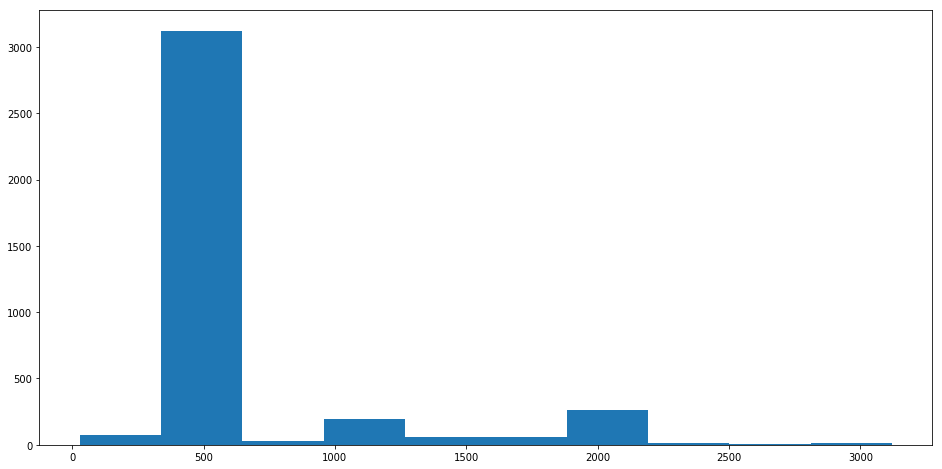

In [41]:
plt.figure(figsize=(16, 8))
plt.hist(building_date_range_list)
plt.show()
plt.close()

* by number of profiles

In [43]:
building_date_range_list = []

count = 0
for (d, b), df in grouped_profiles:
    building_date_range_list.append(df.shape[0])

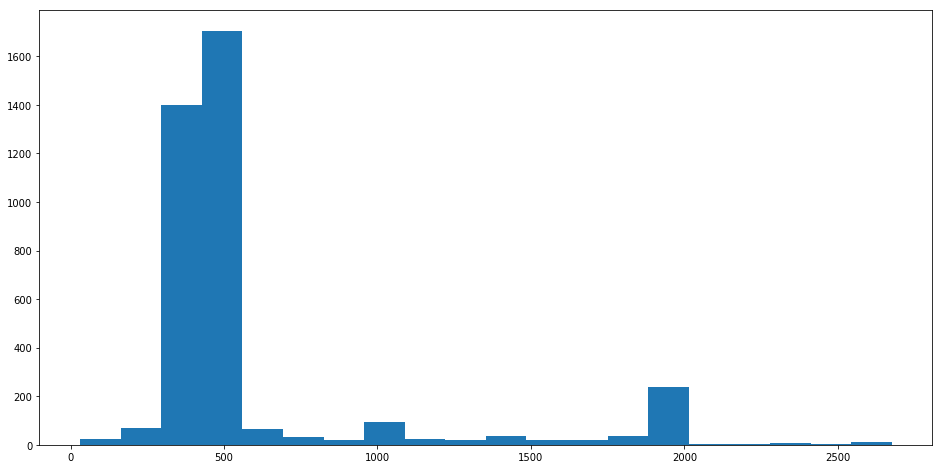

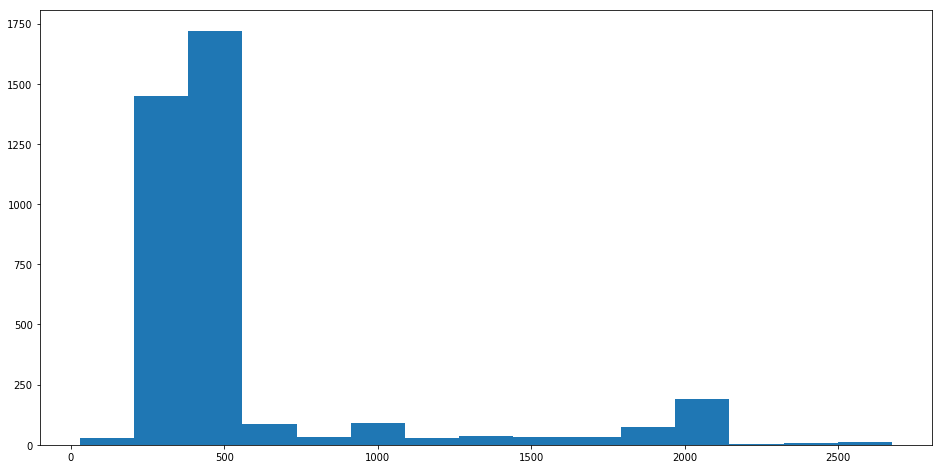

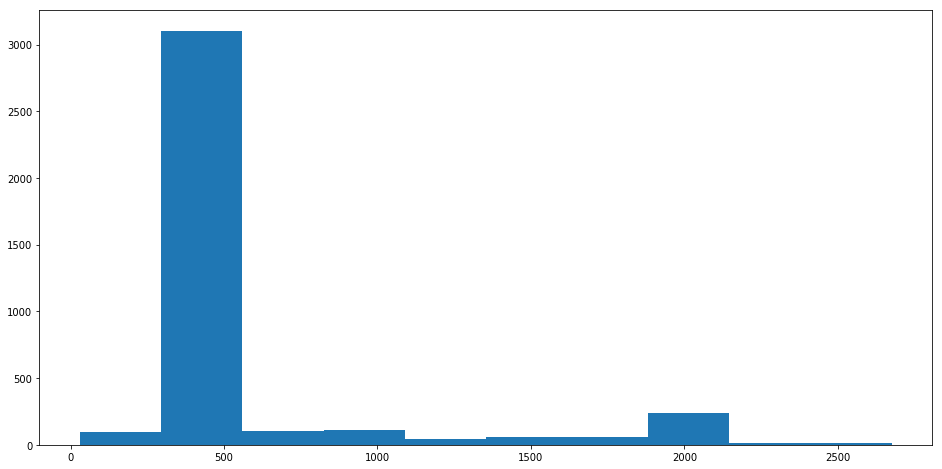

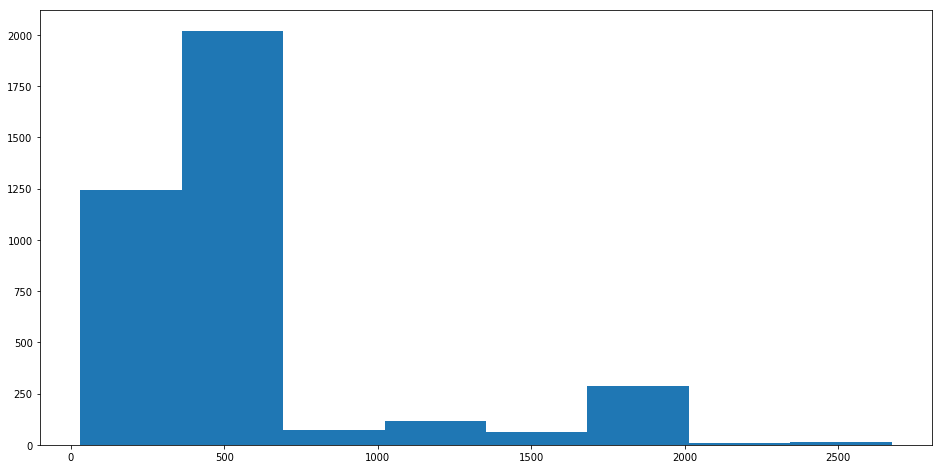

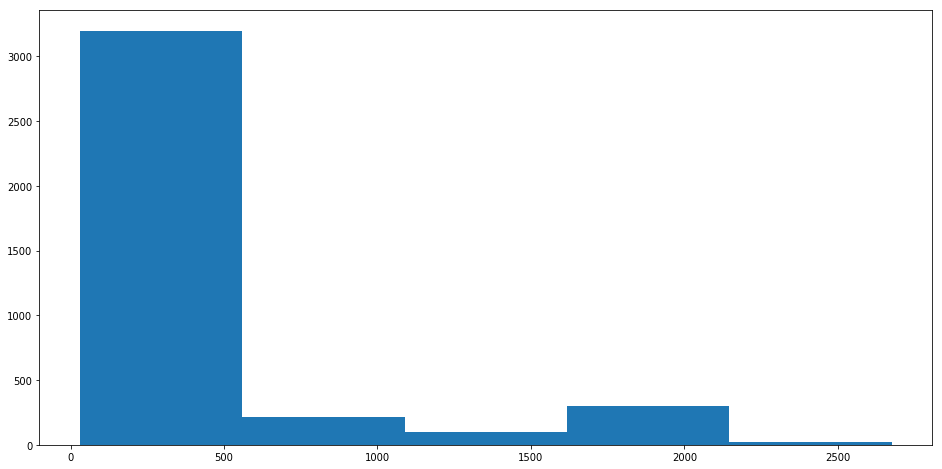

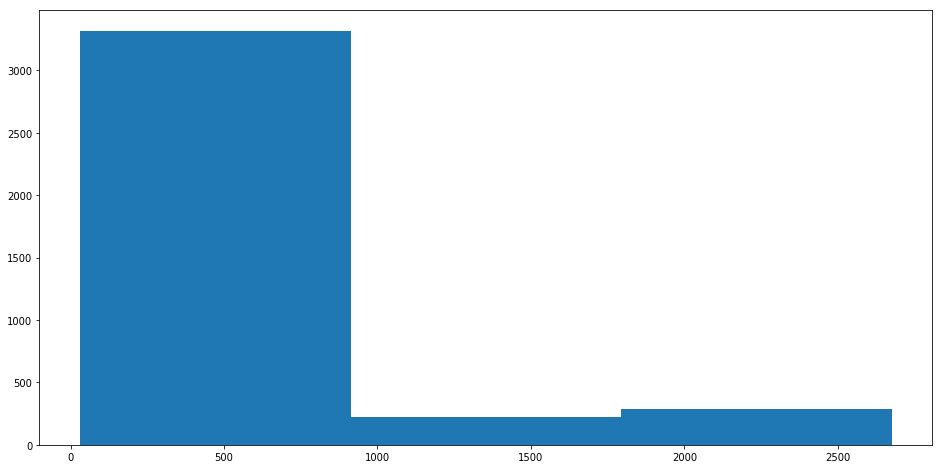

In [46]:
for i in [20, 15, 10, 8, 5, 3]:
    plt.figure(figsize=(16, 8))
    plt.hist(building_date_range_list, bins=i)
    plt.show()
    plt.close()